In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [9]:
df = pd.read_csv('data/processed/master_file_annuel.csv')
df['annee'] = df['annee'].astype(int)

# On filtre à partir de 2010 (début de la VaD et du Replay pour l'Axe 1)
df_subst = df[df['annee'] >= 2010].copy()

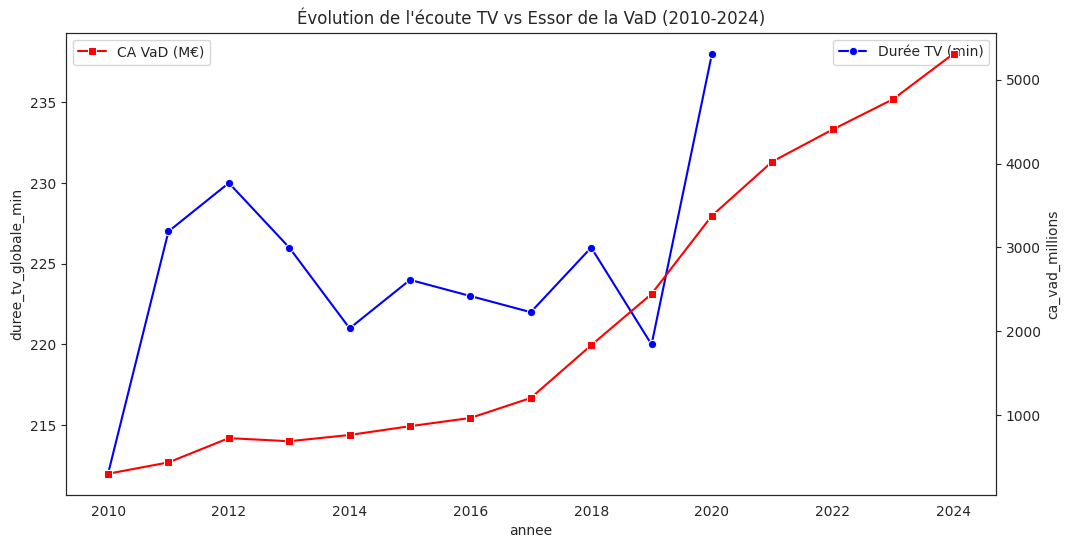

In [10]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_subst, x='annee', y='duree_tv_globale_min', label='Durée TV (min)', color='blue', marker='o')
ax2 = plt.twinx()
sns.lineplot(data=df_subst, x='annee', y='ca_vad_millions', label='CA VaD (M€)', color='red', marker='s', ax=ax2)
plt.title("Évolution de l'écoute TV vs Essor de la VaD (2010-2024)")
plt.show()

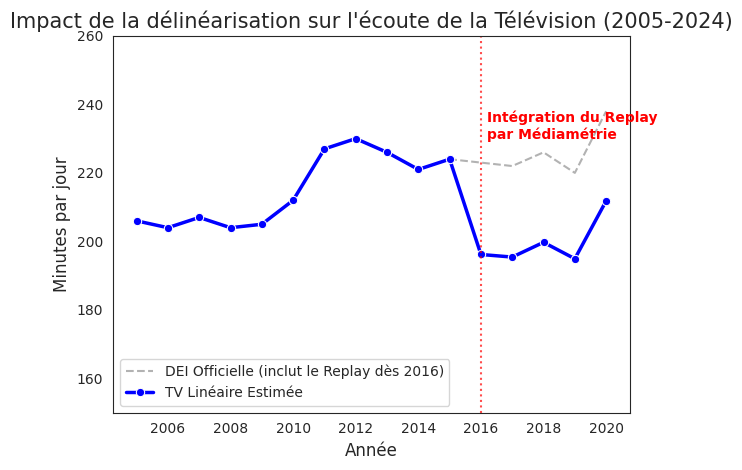

In [11]:
def get_pure_linear(row):
    if row['annee'] >= 2016:
        # Soustraction du poids du replay (Pénétration * Facteur de temps passé)
        correction = (row['taux_replay_pourcent'] / 100) * 0.15
        return row['duree_tv_globale_min'] * (1 - correction)
    return row['duree_tv_globale_min']

df['duree_tv_lineaire_pure'] = df.apply(get_pure_linear, axis=1)

sns.lineplot(data=df[df['annee'] >= 2005], x='annee', y='duree_tv_globale_min',
             label='DEI Officielle (inclut le Replay dès 2016)',
             color='gray', linestyle='--', alpha=0.6)

# Courbe de la donnée corrigée (TV Linéaire Pure)
sns.lineplot(data=df[df['annee'] >= 2005], x='annee', y='duree_tv_lineaire_pure',
             label='TV Linéaire Estimée',
             color='blue', linewidth=2.5, marker='o')

# Mise en évidence du point de rupture de 2016
plt.axvline(x=2016, color='red', linestyle=':', alpha=0.7)
plt.text(2016.2, 230, "Intégration du Replay\npar Médiamétrie", color='red', fontweight='bold')

plt.title("Impact de la délinéarisation sur l'écoute de la Télévision (2005-2024)", fontsize=15)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Minutes par jour", fontsize=12)
plt.legend(loc='lower left')
plt.ylim(150, 260) # Ajuste selon tes données pour bien voir la cassure

plt.tight_layout()
plt.show()

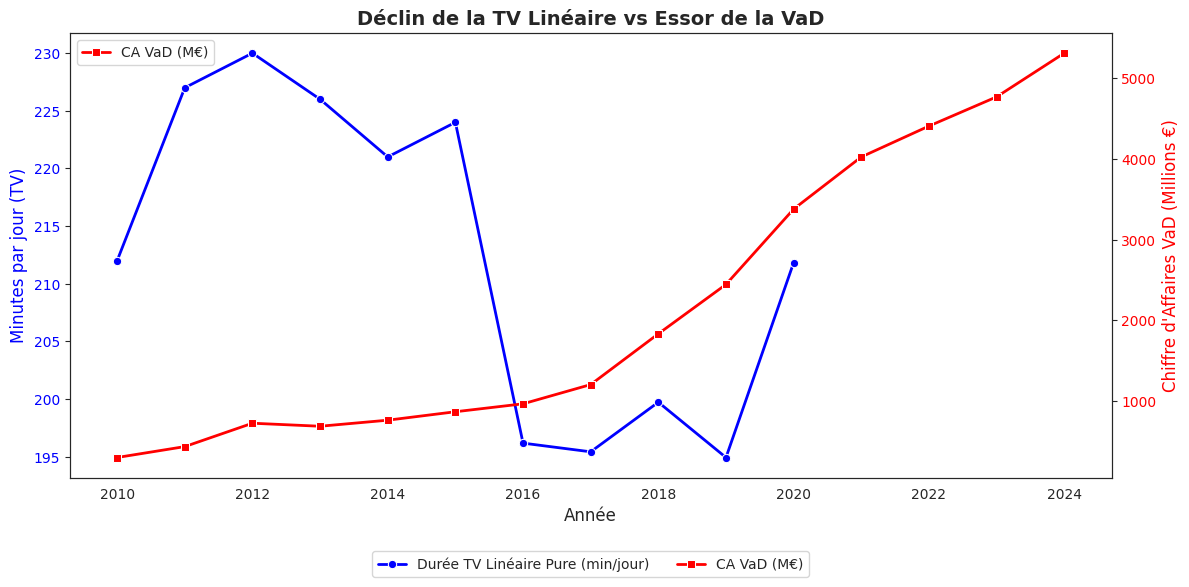

In [16]:
df = pd.read_csv('data/processed/master_file_annuel.csv')

# 2. Définition de la fonction de correction (si pas déjà faite dans une cellule précédente)
def get_pure_linear(row):
    if row['annee'] >= 2016:
        # On retire l'impact du Replay (environ 15% du temps pour les utilisateurs du replay)
        correction = (row['taux_replay_pourcent'] / 100) * 0.15
        return row['duree_tv_globale_min'] * (1 - correction)
    return row['duree_tv_globale_min']

# 3. CRÉATION DE LA COLONNE SUR LE DATAFRAME PRINCIPAL
df['duree_tv_lineaire_pure'] = df.apply(get_pure_linear, axis=1)

# 4. CRÉATION DE LA COPIE FILTRÉE (Après avoir ajouté la colonne)
df_subst = df[df['annee'] >= 2010].copy()

# 5. GÉNÉRATION DU GRAPHIQUE
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("white")

# Courbe de la Durée TV Pure (Axe gauche)
sns.lineplot(data=df_subst, x='annee', y='duree_tv_lineaire_pure',
             label='Durée TV Linéaire Pure (min/jour)',
             color='blue', marker='o', ax=ax1, linewidth=2)

ax1.set_ylabel('Minutes par jour (TV)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Année', fontsize=12)

# Courbe du CA VaD (Axe droit)
ax2 = ax1.twinx()
sns.lineplot(data=df_subst, x='annee', y='ca_vad_millions',
             label='CA VaD (M€)',
             color='red', marker='s', ax=ax2, linewidth=2)

ax2.set_ylabel('Chiffre d\'Affaires VaD (Millions €)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red') # Correction du labelcolor ici

# Titre et légendes
plt.title("Déclin de la TV Linéaire vs Essor de la VaD", fontsize=14, fontweight='bold')

# Fusion des légendes des deux axes pour les mettre en bas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
plt.show()

In [17]:
df_reg = df[df['annee'] >= 2010].dropna(subset=['duree_tv_lineaire_pure', 'ca_vad_millions'])

Y = df_reg['duree_tv_lineaire_pure']
X = df_reg[['ca_vad_millions', 'taux_replay_pourcent']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

# 4. Affichage des résultats
print("--- RÉSULTATS DE LA RÉGRESSION (TV LINÉAIRE CORRIGÉE) ---")
print(model.summary())

--- RÉSULTATS DE LA RÉGRESSION (TV LINÉAIRE CORRIGÉE) ---
                              OLS Regression Results                              
Dep. Variable:     duree_tv_lineaire_pure   R-squared:                       0.399
Model:                                OLS   Adj. R-squared:                  0.248
Method:                     Least Squares   F-statistic:                     2.653
Date:                    Wed, 14 Jan 2026   Prob (F-statistic):              0.131
Time:                            08:59:15   Log-Likelihood:                -41.239
No. Observations:                      11   AIC:                             88.48
Df Residuals:                           8   BIC:                             89.67
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

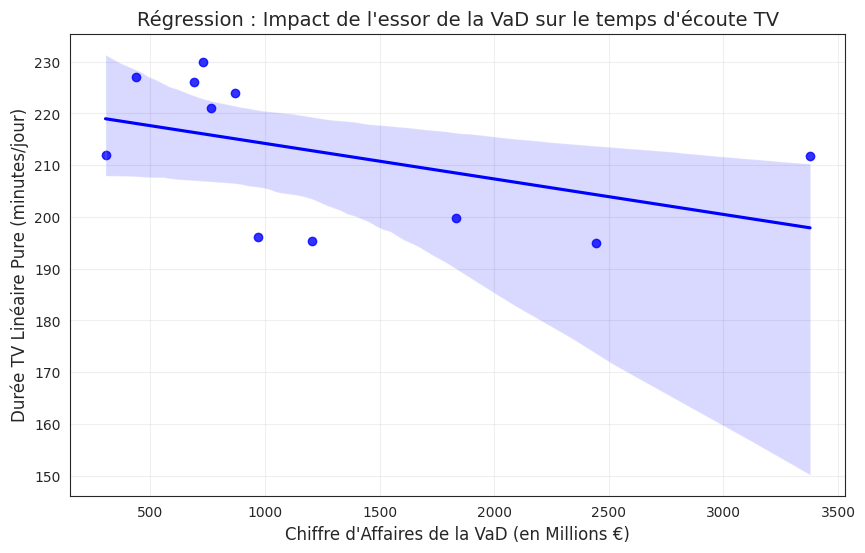

In [30]:
df_plot = df_reg.dropna(subset=['duree_tv_lineaire_pure', 'ca_vad_millions']).copy()

# 2. Création du graphique
plt.figure(figsize=(10, 6))


# On trace la droite de régression
sns.regplot(data=df_plot, x='ca_vad_millions', y='duree_tv_lineaire_pure',
            scatter=True, color='blue', label='Tendance (Régression)')

# Habillage
plt.title("Régression : Impact de l'essor de la VaD sur le temps d'écoute TV", fontsize=14)
plt.xlabel("Chiffre d'Affaires de la VaD (en Millions €)", fontsize=12)
plt.ylabel("Durée TV Linéaire Pure (minutes/jour)", fontsize=12)

# Annotation du coefficient
coef_vad = model.params['ca_vad_millions']


plt.grid(True, alpha=0.3)
plt.show()